In [1]:
!pip install powerlaw
!pip install countryinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 602.2/602.2 kB 9.7 MB/s eta 0:00:00


In [2]:
# Importing the libraries
import os  # Used for file operations
import requests  # Used for making HTTP requests
from bs4 import BeautifulSoup  # Used for parsing HTML
import re  # Used for regular expressions
import pandas as pd  # Used for data manipulation and analysis
import numpy as np  # Used for numerical computations
from tqdm import tqdm  # Used for progress bars
import time  # Used for time operations
import xml.etree.ElementTree as ET  # Used for parsing XML
import ipytree # Used for displaying the XML tag hierarchy in a dynamic tree-like structure
import json  # Used for JSON operations (used for the XML tag hierarchy)
import ast  # Used for converting string to list
import matplotlib.pyplot as plt  # Used for plotting graphs
import networkx as nx  # Used for creating and analyzing the network
import seaborn as sns  # Used for plotting graphs
from IPython.display import Image  # Used for displaying images in the notebook
import imageio.v2 as imageio  # Used for creating GIFs
import powerlaw  # Used for fitting power-law distributions
from countryinfo import CountryInfo  # Used for getting country information
import copy  # Used to copy nested dictionaries
import random  # Used for random operations
import plotly.graph_objects as go  # Used for creating interactive plots
import math  # Used for mathematical operations

## 5. Network Transformation
In this section, we will create a function that will transform the existing collaboration network of the data scientists into a new network. The new network will be transformed based on the following goals:
- The maximum degree of any node will not exceed beyond a user-specified k_max, referred to as collaboration cutoff, which is typically smaller than the degrees of hubs.
- The transformed network has smaller giant component and larger number of isolates than the original collaboration network.
- The transformed network is being built to identify links between High Degree (Famous Data Scientists) & Low Degree nodes (their less famous co-authors)  

To maintain the diversity of nodes in the network, we decided against removing any nodes from the network. Therefore, the transformed network will have the same no of nodes as the untransformed network. We instead focus on removing unwanted edges from the network. In general every network transformation technique we tried had 2 parts:
1. Define a metric of edge importance
2. Define a policy to prune edges of less importance

In [32]:
# Define the collaboration network from the JSON
collaboration_network = json.load(open('/content/network.json', 'r'))

# Simplying collaboration_network (To make the code lighter to read)
network = {}
for node, neighbours in collaboration_network.items():
    for neighbour, weight_dict in neighbours.items():
        if node in network:
            network[node][neighbour] = 1  # Weights are not taken into consideration
        else:
            network[node] = {neighbour: 1}
    # Check if the node has no neighbours
    if neighbours == {}:
        network[node] = {}
print(len(network.keys()))

1052


### 5.1 Best Reduction Model - Hard Cutoff for Normalised Degree Difference
In this section we discuss the technique which was the most successful at reducing the size of the giant component. This technique has two parts:

I) **Edge Importance Metric** - To measure the importance of each edge we defined a metric Normalised Degree Difference as:

$$ NormalisedDegreeDifference (E_{n1, n2}) = {|{C_d(n1) - C_d(n2)}| \over max(C_d(n1), C_d(n2))} $$  

where n1 and n2 are nodes in the graph, E_n1_n2 is the edge connecting n1 & n2, and C_d(x) is the degree of node x. The expected values of Normalised Degree Difference for different edges are:
1. Hub - Hub Edges: Small Numerator and Large Denominator => Very Small - Small Value
2. Hub - Normal Edges: Large Numerator and Large Denominator => Medium - Large Value
3. Normal - Normal Edges: Small Numerator and Small Denominator => Small - Medium Value

II) **Edge Pruning Policy** - To prune the edges in the network, we define a hard cutoff, calculated based on the user specified k_max. All edges with an edge importance below this threshold will be removed from the network.

#### 5.1.1 Calculate Normalised Degree Difference for each Edge

In [33]:
# Calculating Normalised Degree Difference for each edge
norm_degree_diff_network = copy.deepcopy(network)
for node, neighbours in network.items():
    for neighbour, weight in neighbours.items():
        norm_degree_diff = abs(len(network[node]) - len(network[neighbour])) / max(
            (len(network[node]), len(network[neighbour])))
        norm_degree_diff_network[node][neighbour] = norm_degree_diff

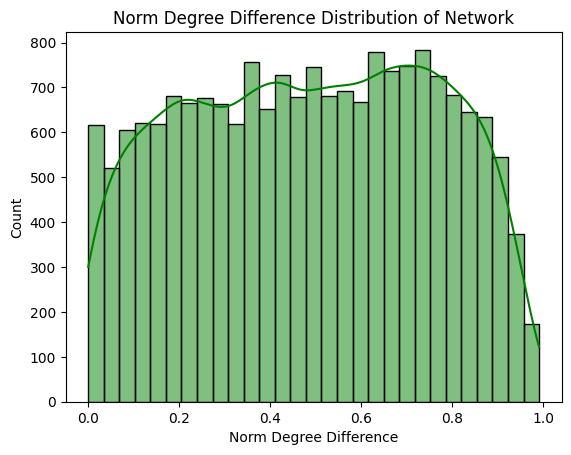

Norm Degree Difference Distribution Statistics:
count    18712.000000
mean         0.484846
std          0.267748
min          0.000000
25%          0.255814
50%          0.495858
75%          0.714286
max          0.990991
dtype: float64


In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Visualising the distribution of normalised degree difference in the network
norm_degree_diff_distribution = []
for node, neighbours in norm_degree_diff_network.items():
    for neighbour, weight in neighbours.items():
        norm_degree_diff_distribution.append(weight)

# Change color here
sns.histplot(data=norm_degree_diff_distribution, kde=True, color='green')
plt.title('Norm Degree Difference Distribution of Network')
plt.xlabel('Norm Degree Difference')
# plt.yscale("log")
plt.ylabel("Count")
plt.show()

print(f"Norm Degree Difference Distribution Statistics:\n{pd.Series(norm_degree_diff_distribution).describe()}")


#### 5.1.2 Find the minimum threshold to satisfy k_max & Prune Network

In [36]:
def find_hard_minimum_threshold_weight(network: dict, k_max: int) -> float:
    """Given k_max this function calculates the minimum threshold weight such that
       k_max is enforced when all edges below that threshold are removed from the
       network."""
    min_weight_threshold = 0.0
    for node, neighbours in tqdm(network.items()):
        if len(neighbours) > k_max:
            no_nodes_to_remove = len(neighbours) - k_max
            weights_list = list(neighbours.values())
            weights_list.sort()
            candidate_min_weight_threshold = weights_list[no_nodes_to_remove - 1]  # -1 is correction for zero indexing
            if candidate_min_weight_threshold > min_weight_threshold:
                min_weight_threshold = candidate_min_weight_threshold

    return min_weight_threshold


def prune_network_on_min_weight_threshold(network: dict, min_weight_threshold: float) -> dict:
    """Returns the network after pruning all edges below min_weight_threshold"""
    pruned_network = copy.deepcopy(network)
    for node, neighbours in tqdm(network.items()):
        for neighbour, weight in neighbours.items():
            if weight <= min_weight_threshold:
                pruned_network[node].pop(neighbour)

    return pruned_network

In [37]:
min_norm_degree = find_hard_minimum_threshold_weight(network=norm_degree_diff_network, k_max=60)
transformed_network = prune_network_on_min_weight_threshold(norm_degree_diff_network, min_norm_degree)

100%|██████████| 1052/1052 [00:00<00:00, 257538.54it/s]


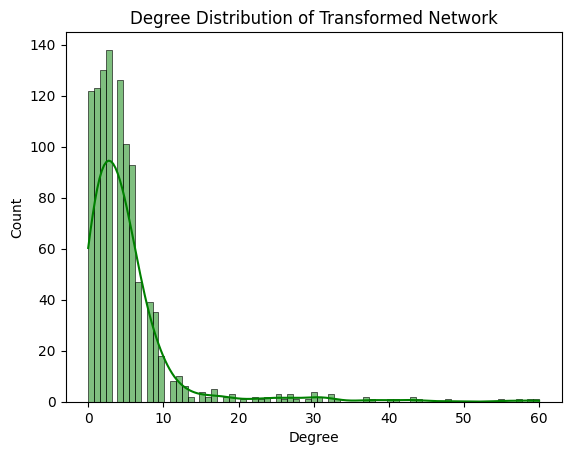

Transformed Network Degree Distribution Statistics:
count    1052.000000
mean        5.106464
std         6.762948
min         0.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        60.000000
dtype: float64


In [39]:
# Visualising the degree distribution of the transformed_network
degree_distribution = []
for neighbours_dict in transformed_network.values():
    degree_distribution.append(len(neighbours_dict))

sns.histplot(data=degree_distribution, kde=True, color = 'green')
plt.title('Degree Distribution of Transformed Network')
plt.xlabel('Degree')
# plt.yscale("log")
plt.ylabel("Count")
plt.show()

print(f"Transformed Network Degree Distribution Statistics:\n{pd.Series(degree_distribution).describe()}")

#### 5.1.3 Analysing the relation between k_max and giant component size

In [40]:
def get_network_components(network: dict) -> list:
    """Returns a list of sets where each set is a connected cluster of nodes"""

    def find_node_cluster(cluster_map, node):
        """Returns the head node of a cluster if the node is in a cluster otherwise it returns None"""
        for head_node, node_set in cluster_map.items():
            if node in node_set:
                return head_node

        return None

    # Isolating the different components
    cluster_map = {}
    for node, neighbours in network.items():
        # 1) Check if current node is in a cluster
        current_node_cluster = find_node_cluster(cluster_map, node)

        # 2) If node is not in a cluster create a new one
        if current_node_cluster is None:
            current_node_cluster = node
            cluster_map[current_node_cluster] = set([node])

        clusters_to_be_merged = set()
        for neighbour in neighbours.keys():
            # 3) If neighbour is part of another cluster mark the cluster for merging
            neighbour_cluster = find_node_cluster(cluster_map, neighbour)
            if (neighbour_cluster is not None) and (neighbour_cluster != current_node_cluster):
                clusters_to_be_merged.add(neighbour_cluster)
            elif neighbour_cluster != current_node_cluster:
                # 4) Add neighbouring nodes to the current cluster
                cluster_map[current_node_cluster].add(neighbour)

        # 5) Merge the clusters that need to be merged
        for cluster in clusters_to_be_merged:
            cluster_content = cluster_map[cluster]
            cluster_map[current_node_cluster] = cluster_map[current_node_cluster].union(cluster_content)
            cluster_map.pop(cluster)

    return list(cluster_map.values())


def get_giant_component_size(network: dict) -> list:
    components = get_network_components(network)
    return max([len(c) for c in components])

100%|██████████| 1052/1052 [00:00<00:00, 194610.67it/s]


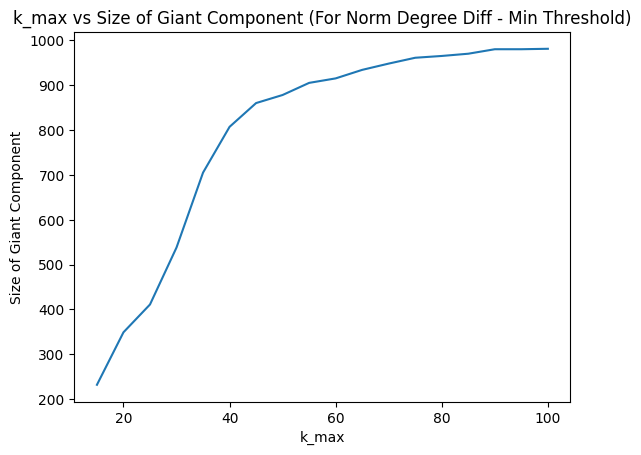

In [13]:
# Analysing relation between k_max and size of giant component
k_max_list = list(range(100, 10, -5))
giant_component_size = []
for k_max in k_max_list:
    min_norm_degree = find_hard_minimum_threshold_weight(network=norm_degree_diff_network, k_max=k_max)
    transformed_network = prune_network_on_min_weight_threshold(norm_degree_diff_network, min_norm_degree)
    giant_component_size.append(get_giant_component_size(transformed_network))

sns.lineplot(x=k_max_list, y=giant_component_size)
plt.title('k_max vs Size of Giant Component (For Norm Degree Diff - Min Threshold)')
plt.xlabel('k_max')
plt.ylabel("Size of Giant Component")
plt.show()

In [41]:
K_MAX = 35
min_norm_degree = find_hard_minimum_threshold_weight(network=norm_degree_diff_network, k_max=K_MAX)
transformed_network = prune_network_on_min_weight_threshold(norm_degree_diff_network, min_norm_degree)

print(f"K_MAX = {K_MAX}")
print(f"Size of Giant Component is: {get_giant_component_size(transformed_network)}")
degree_distribution = [len(v) for v in transformed_network.values()]
amt_of_zero_degree_nodes = sum([(1 if len(v) == 0 else 0) for v in transformed_network.values()])
print(f"There are {amt_of_zero_degree_nodes} out of {len(transformed_network)} with a degree of zero.")

# Saving Transfromed Network
with open("./transformed_network.json", "w") as f1:
    json.dump(transformed_network, f1, indent=4)

100%|██████████| 1052/1052 [00:00<00:00, 262627.69it/s]

K_MAX = 35
Size of Giant Component is: 705
There are 281 out of 1052 with a degree of zero.


In [42]:

# Define a function to generate the Graph from the collaboration network JSON file
def generate_graph(collaboration_network, weight_key='collaborations'):
    G = nx.Graph()
    # Add the links between the authors
    for author, collaborators in collaboration_network.items():
        for collaborator, details in collaborators.items():
            G.add_edge(author, collaborator, weight=details[weight_key])
    # Add the nodes that have no connections
    for author in collaboration_network.keys():
        if collaboration_network[author] == {}:
            G.add_node(author)
    return G

1052
The Graph has 1052 nodes and 1170 edges


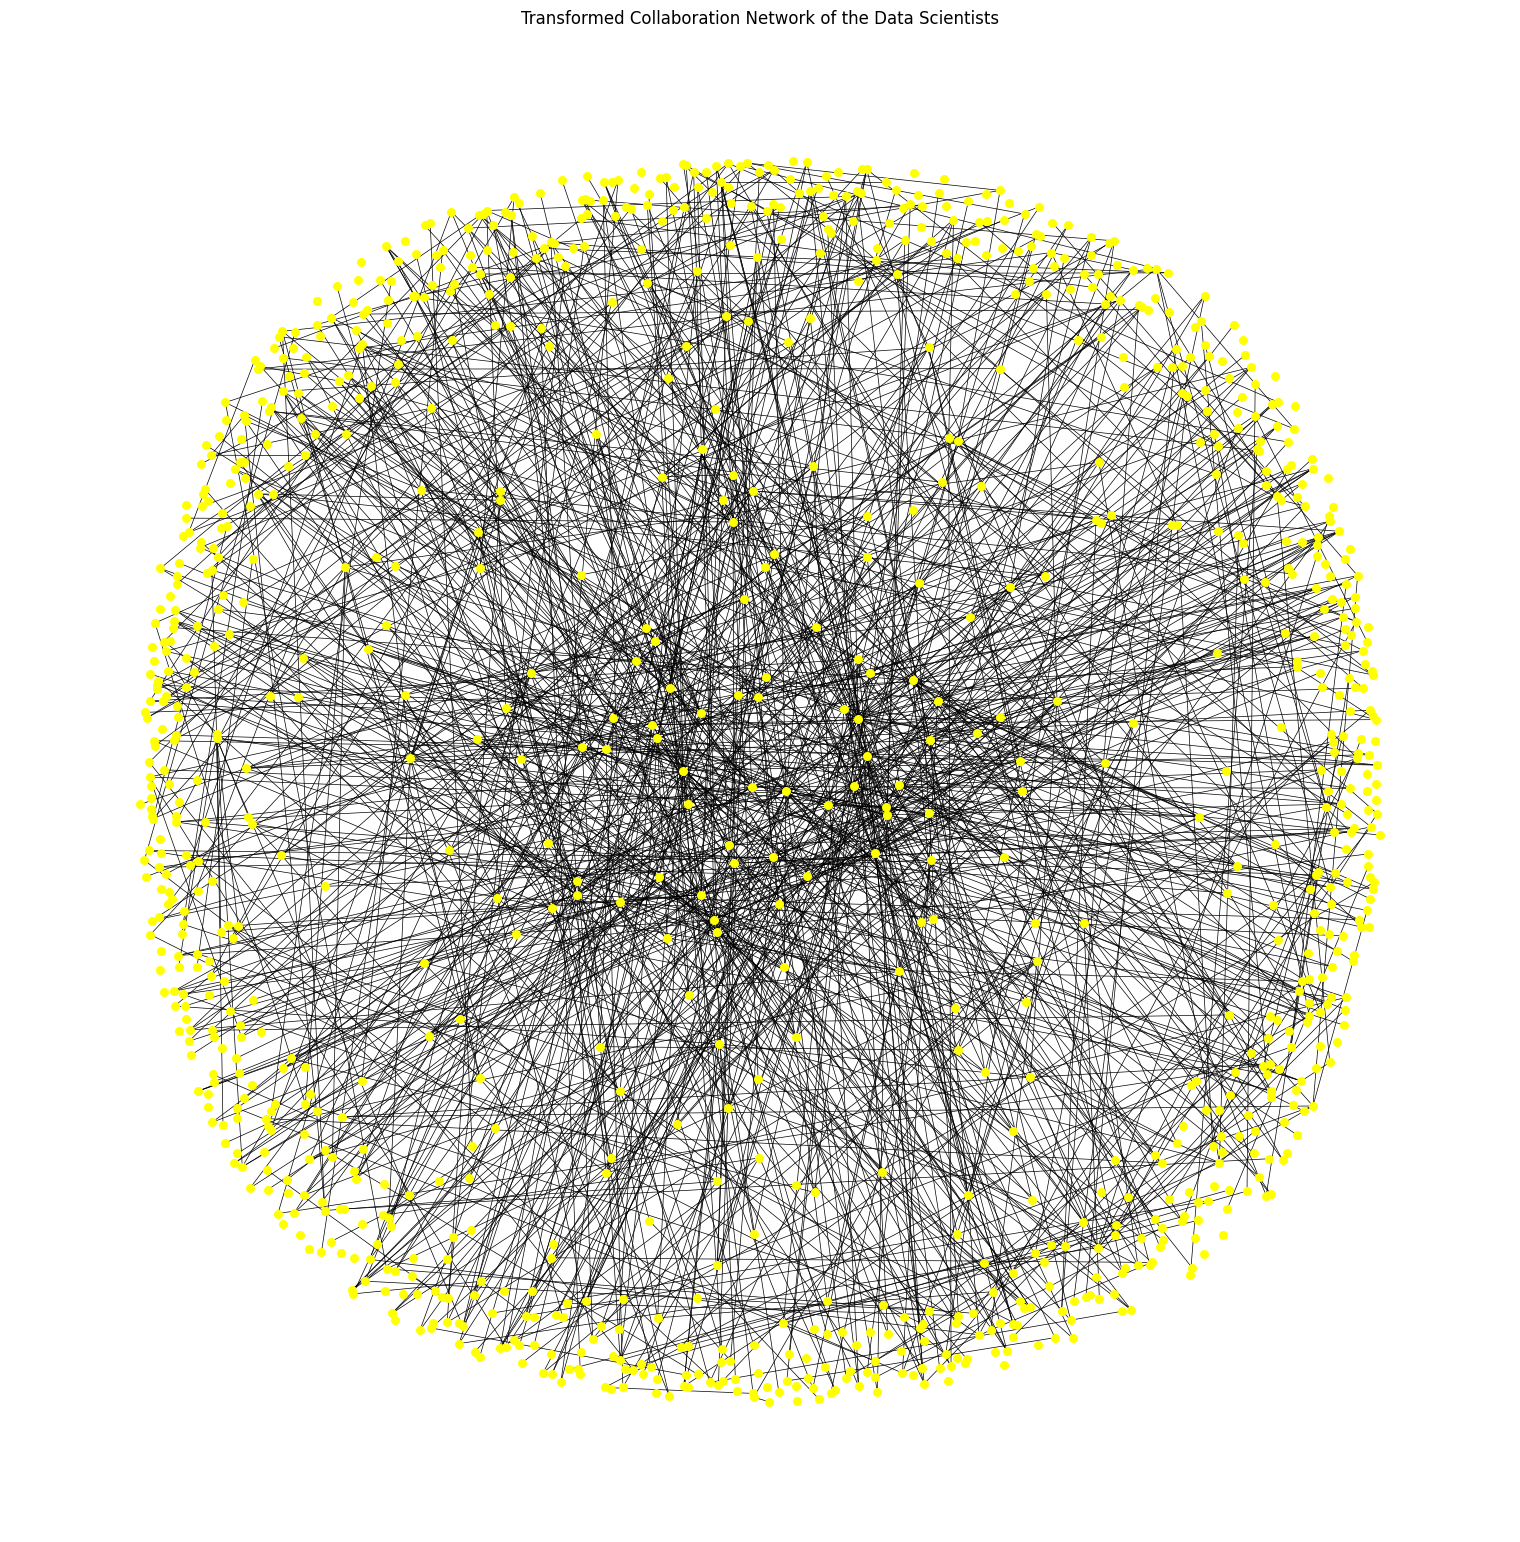

In [44]:
# Generate the Graph from the collaboration network
transformed_network_2 = copy.deepcopy(transformed_network)
for node, neighbours in transformed_network.items():
    for neighbour, weight in neighbours.items():
        transformed_network_2[node][neighbour] = {'weight': 1}
print(len(transformed_network_2.keys()))
G = generate_graph(transformed_network_2, weight_key='weight')

# Display the number of nodes and edges in the Graph
print(f'The Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges')

# Display the Graph
plt.figure(figsize=(15, 15))
plt.tight_layout()
pos = nx.spring_layout(G, seed=42, k=0.6)
nx.draw(G, pos, with_labels=False, node_size=30, edge_color='black', node_color='yellow',
        width=0.5)  # Decrease node_size and set with_labels to False
plt.title('Transformed Collaboration Network of the Data Scientists')
# Save the plot as a PNG file in the 'plots' directory
#plt.savefig(plots_dir + 'transformed_network_graph.png', bbox_inches='tight')
plt.show()

#### 5.1.5 Transformed Network vs Original Network - Country, Expertise and Institution Distribution
Now, we will analyse the country, expertise and institution distribution of the nodes in the transformed network and compare it with the original network because we want to ensure that the diversity of the nodes in the network is maintained.

In [45]:
def get_param_degree(G, data_scientists, param='country'):
    param_degrees = {}
    for node in G.nodes():
        # Fix: Check if the node exists in data_scientists before accessing
        if node in data_scientists['pid'].values:
            p = data_scientists.loc[data_scientists['pid'] == node, param].values[0]
            # Check if the country is not available
            if pd.isnull(p):
                continue
            if param != 'expertise':
                # Check if the country is a set
                if '{' in p:
                    # Convert the string to a set
                    p = ast.literal_eval(p)
                    # Get the first country in the set
                    p = list(p)[0]
            if p in param_degrees:
                param_degrees[p] += nx.degree(G, node)
            else:
                param_degrees[p] = nx.degree(G, node)
    # Compute the average node degree for each country
    for p in param_degrees:
        param_degrees[p] = np.mean(param_degrees[p])
    return param_degrees

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43],
 [Text(0, 0, 'united states'),
  Text(1, 0, 'china'),
  Text(2, 0, 'germany'),
  Text(3, 0, 'hong kong sar'),
  Text(4, 0, 'singapore'),
  Text(5, 0, 'india'),
  Text(6, 0, 'canada'),
  Text(7, 0, 'switzerland'),
  Text(8, 0, 'australia'),
  Text(9, 0, 'france'),
  Text(10, 0, 'greece'),
  Text(11, 0, 'italy'),
  Text(12, 0, 'denmark'),
  Text(13, 0, 'united kingdom'),
  Text(14, 0, 'netherlands'),
  Text(15, 0, 'south korea'),
  Text(16, 0, 'israel'),
  Text(17, 0, 'taiwan'),
  Text(18, 0, 'brazil'),
  Text(19, 0, 'japan'),
  Text(20, 0, 'qatar'),
  Text(21, 0, 'finland'),
  Text(22, 0, 'austria'),
  Text(23, 0, 'sweden'),
  Text(24, 0, 'turkey'),
  Text(25, 0, 'belgium'),
  Text(26, 0, 'new zealand'),
  Text(27, 0, 'crete'),
  Text(2

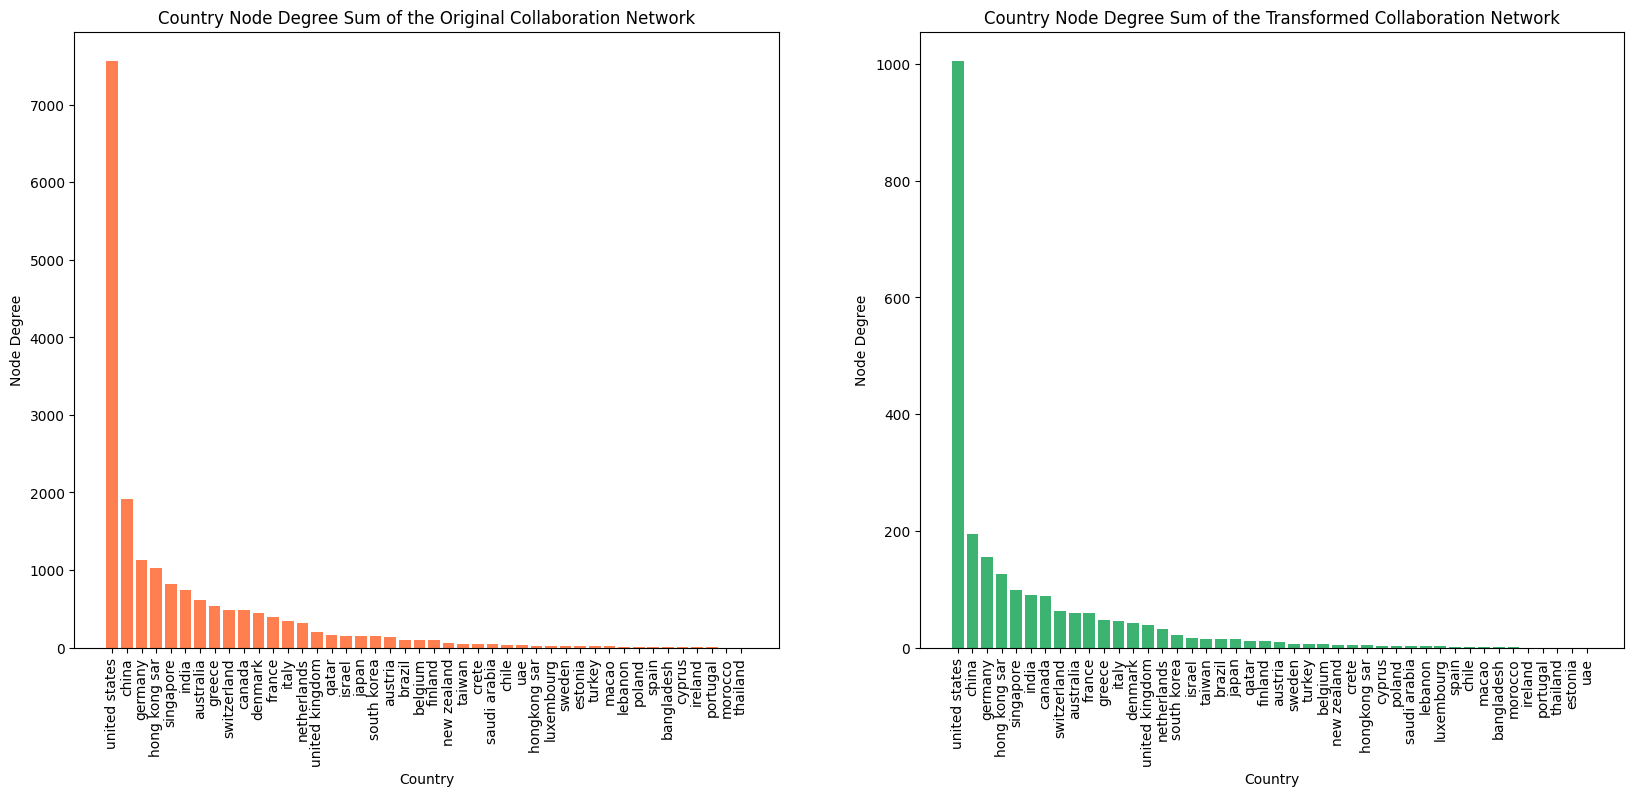

In [48]:
# Import the data of the data scientists
data_scientists = pd.read_csv('/content/scientists_cleaned.csv')

# Get the collaboration network data from the JSON file
collaboration_network = json.load(open('/content/network.json', 'r'))

# Get the network graph of the original collaboration network
G_original = generate_graph(collaboration_network)
# Get the network graph of the transformed collaboration network
G_transformed = generate_graph(transformed_network_2, weight_key='weight')

# Get the country node degree sum of the original collaboration network
country_degree_original = get_param_degree(G_original, data_scientists)
# Get the country node degree sum of the transformed collaboration network
country_degree_transformed = get_param_degree(G_transformed, data_scientists)

# Sort the country node degree sum dictionaries
country_degree_original = dict(sorted(country_degree_original.items(), key=lambda item: item[1], reverse=True))
country_degree_transformed = dict(sorted(country_degree_transformed.items(), key=lambda item: item[1], reverse=True))

# Plot the country node degree sum of the original and transformed collaboration networks side by side
plt.figure(figsize=(20, 8))

# Plot the country node degree sum of the original collaboration network
plt.subplot(1, 2, 1)
plt.bar(list(country_degree_original.keys()), list(country_degree_original.values()), color='coral')
plt.title('Country Node Degree Sum of the Original Collaboration Network')
plt.xlabel('Country')
plt.ylabel('Node Degree')
plt.xticks(rotation=90)

# Plot the country node degree sum of the transformed collaboration network
plt.subplot(1, 2, 2)
plt.bar(list(country_degree_transformed.keys()), list(country_degree_transformed.values()), color='mediumseagreen')
plt.title('Country Node Degree Sum of the Transformed Collaboration Network')
plt.xlabel('Country')
plt.ylabel('Node Degree')
plt.xticks(rotation=90)

# Save the plot as a PNG file in the 'plots' directory
#plt.savefig(plots_dir + 'country_node_degree_original_transformed.png', bbox_inches='tight')

Again, as we can see, the expertise node degree sum of the transformed collaboration network is similar to the original collaboration network. This indicates that the diversity of the nodes in the network is maintained after the transformation. Lastly, we will compare the institution distribution of the nodes in the transformed network with the original network.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'microsoft'),
  Text(1, 0, 'mit'),
  Text(2, 0, 'university of michigan'),
  Text(3, 0, 'google'),
  Text(4, 0, 'new york university'),
  Text(5, 0, 'university of waterloo'),
  Text(6, 0, 'national university of singapore'),
  Text(7, 0, 'at&t'),
  Text(8, 0, 'microsoft research'),
  Text(9, 0, 'facebook')])

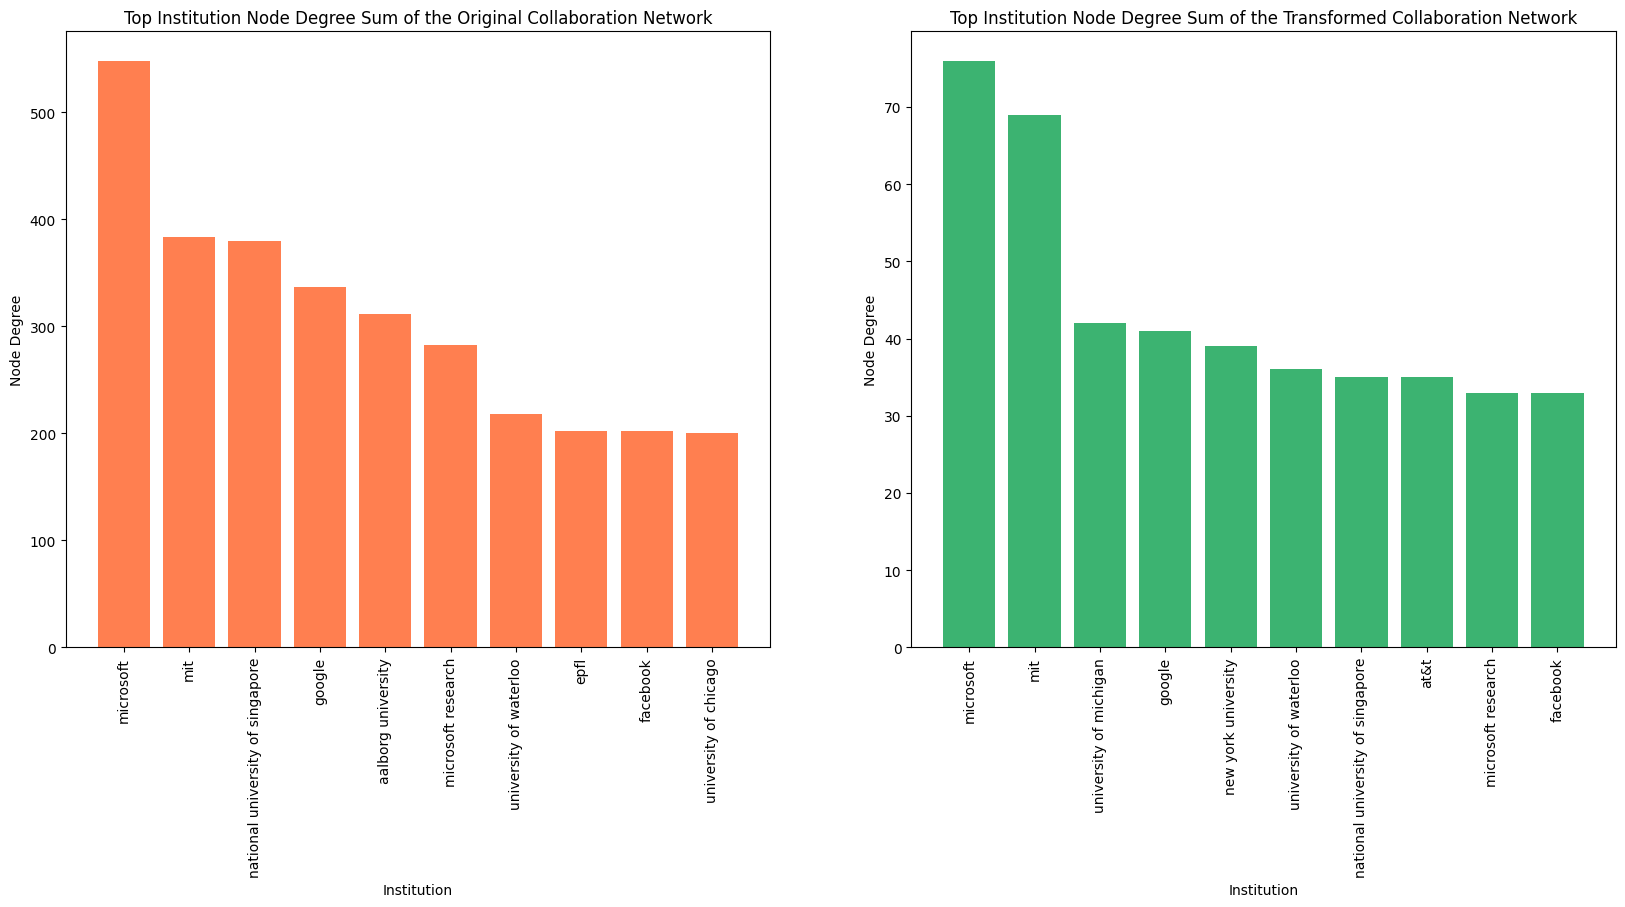

In [49]:
# Get the institution node degree sum of the original collaboration network
institution_degree_original = get_param_degree(G_original, data_scientists, param='institution')
# Get the institution node degree sum of the transformed collaboration network
institution_degree_transformed = get_param_degree(G_transformed, data_scientists, param='institution')

# Sort the institution node degree sum dictionaries
institution_degree_original = dict(sorted(institution_degree_original.items(), key=lambda item: item[1], reverse=True))
institution_degree_transformed = dict(sorted(institution_degree_transformed.items(), key=lambda item: item[1], reverse=True))

# Get the top 10 institutions in the original collaboration network
top_institutions_original = dict(list(institution_degree_original.items())[:10])
# Get the top 10 institutions in the transformed collaboration network
top_institutions_transformed = dict(list(institution_degree_transformed.items())[:10])

# Plot the top institution node degree sum of the original and transformed collaboration networks side by side
plt.figure(figsize=(20, 8))

# Plot the institution node degree sum of the original collaboration network
plt.subplot(1, 2, 1)
plt.bar(list(top_institutions_original.keys()), list(top_institutions_original.values()), color='coral')
plt.title('Top Institution Node Degree Sum of the Original Collaboration Network')
plt.xlabel('Institution')
plt.ylabel('Node Degree')
plt.xticks(rotation=90)

# Plot the institution node degree sum of the transformed collaboration network
plt.subplot(1, 2, 2)
plt.bar(list(top_institutions_transformed.keys()), list(top_institutions_transformed.values()), color='mediumseagreen')
plt.title('Top Institution Node Degree Sum of the Transformed Collaboration Network')
plt.xlabel('Institution')
plt.ylabel('Node Degree')
plt.xticks(rotation=90)

# Save the plot as a PNG file in the 'plots' directory
#plt.savefig(plots_dir + 'institution_node_degree_original_transformed.png', bbox_inches='tight')

As we can see, the institution node degree sum of the transformed collaboration network is similar to the original collaboration network. We have some changes in the positions, but they are minor, overall the top 10 institutions with the highest node degree sum are very similar. This indicates that the diversity of the nodes in the network is maintained after the transformation. This concludes the transformation of the collaboration network of the data scientists. In the next section, we will discuss an alternate reduction model we used.